# Note on the Functioning of Logit Lens

This note is based on the article [Interpreting GPT: The Logit Lens](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens#other_examples).


# What is Logit Lens?

*Logit Lens* is used for analyzing the functioning of language models like GPT. Instead of focusing on **how** the model processes data, *Logit Lens* allows us to examine **what** the model predicts as the next token at various stages of text generation. This helps to understand **what the model "thinks" during its operation**.

With *Logit Lens*, we can:
- Peek inside the model and see which words it considers at different layers,
- Check how early the model begins to "guess" what word should appear next — often, by the middle of processing, the model already has accurate predictions about the next token,
- Trace how these predictions change across subsequent layers until the final output.

However, it's important to note that *Logit Lens* shows **only one aspect of the model's operation** – its predictions at various stages. It doesn't answer questions like:

- **How** does the model arrive at these predictions,
- What other information (e.g., intermediate representations, rules, structures) is stored and processed in the network.


# How Does Logit Lens Work?

- **Tokenization**
    The input text, e.g.,

    `"We train GPT-3, an aut..."`
    is split into tokens:

    `["We", " train", " GPT", "-", "3", ",", " an", " aut", ...]`

    In practice, these are often not full words but parts of words or individual characters.

- **Embedding**

    Each token is transformed into a vector of numbers using the **embedding matrix**. This converts the text into a set of numerical vectors. In this way, each token becomes a point in a multidimensional space, where points that are close to each other represent similar meanings.

- **Processing Through GPT Layers**

    The vectors pass through successive **transformer layers**

    Each layer adds new information, such as:

    - Considering the context (what came before?),
    - Recognizing linguistic structures (sentences, syntax),
    - Developing meaning based on the surrounding tokens.

    After each layer, we get **updated vectors** that increasingly "understand" the meaning of the text and what might come next.

- **Standard Model Output**
    At the end of the last layer, we get the final vector representing "what should come next." This vector is transformed by multiplying it by the transpose of the embedding matrix, yielding logits. A softmax applied to these logits gives a probability distribution. The token with the highest probability is selected as the next one.

- **Logit Lens: What Do We Do Differently?**

    Logit Lens performs exactly **the same step**, but **for the vectors from earlier layers**.
    This allows us to see how the model's "types" changed throughout the processing.

    In the standard model operation, logits are computed **only at the end** — after the last layer.

    **Logit Lens allows us to perform exactly the same step (multiplying by transposed matrix, softmax)**, but **for each intermediate layer**

    This way, we can:

    - See **what the model's predictions were** after each layer.
    - Compare whether it **guessed correctly early on**, or if it **changed its mind only towards the end**.


```python
# 1. Input text
input_text = "We train GPT-3, an aut..."

# 2. Tokenization (convert text to token IDs)
input_tokens = tokenize(input_text)

# 3. Convert tokens to embeddings
embedding_vectors = embedding_matrix[input_tokens]  # shape: (sequence_length, 1600)

# 4. Pass through model layers, save hidden states after each layer
hidden_states = []
x = embedding_vectors

for layer in model_layers:
    x = layer(x)
    hidden_states.append(x)  # store output of each layer

# 5. Apply Logit Lens: project each layer's output back into token space
logits_by_layer = []

for h in hidden_states:
    logits = matmul(h, transpose(embedding_matrix))  # project back to vocabulary space
    probs = softmax(logits)  # get probabilities for each token
    logits_by_layer.append(probs) 
```


# What can we learn from reading Logit Lens visualisations?

### 1. Reading Logits

Using the Logit Lens, we can inspect the model’s predictions at **each layer**, not just the final one.

In the example below, we can observe:

- **a)** The input token (what the model is trying to continue).
- **b)** The model’s predicted token at each layer — how these predictions evolve.
- **c)** The final predicted token (after the last layer), and whether it matches the correct continuation.

A crucial part of this visualization is the **color scale**, which indicates the logit values.

Thanks to this, we can spot **where in the network** the model starts making “good guesses” — i.e., where it begins assigning high confidence to the correct or plausible next token.

> 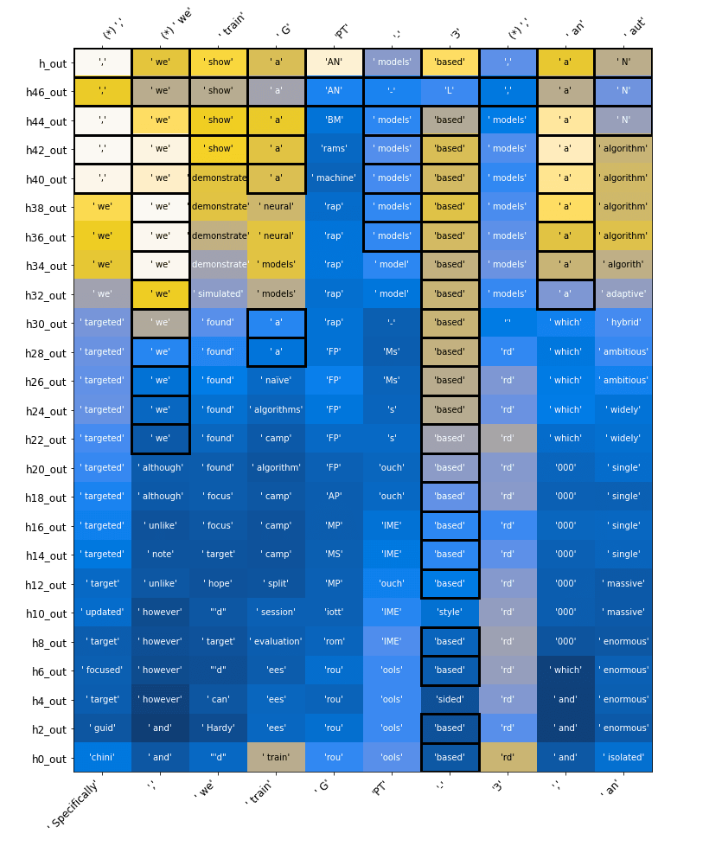



### 2. Reading Ranks

This visualization is similar to logits, but instead of inspecting predicted tokens directly, we look at the **rank** of the correct token at each layer.

This allows us to answer questions like:

- “How close is the model to guessing the right token at layer X?”
- “When does the model start ranking the correct token in its top 10 guesses?”

If the **rank drops below a threshold (e.g. rank < 10)**, it means the model is getting close — the final token is already a top candidate.

> 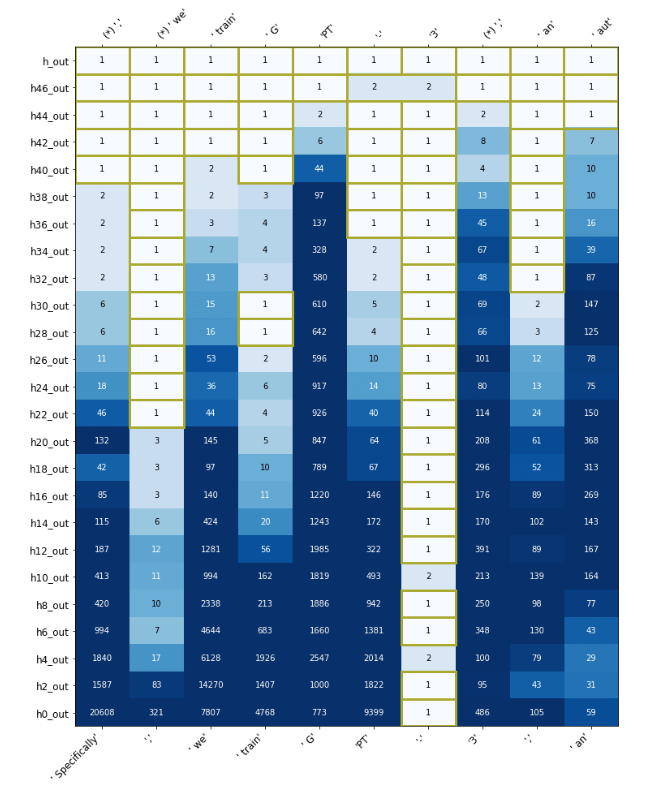

### 3. KL Divergence – How Entire Distributions Evolve

**KL divergence** (Kullback-Leibler divergence) measures **how different one probability distribution is from another**. If two distributions are nearly identical, their KL divergence will be close to **zero**.

In the Logit Lens context, we use KL divergence to ask:
> **How does the model’s predicted distribution change layer by layer?**

---

#### What we observe in the visualization

- The **input vector** is **dramatically different** from everything that follows.
- After **just one layer**, the model's internal state already resembles the **final prediction** more than it resembles the input.
- From that point on, the evolution is **smooth and gradual**, with no more sharp jumps — the network progressively refines its belief about what comes next.

> 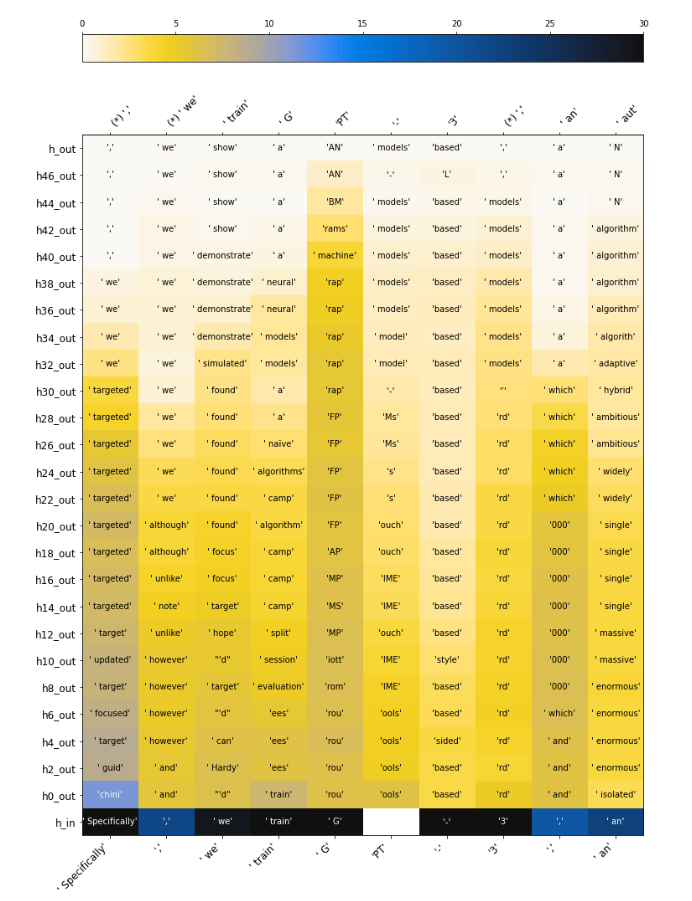

---

This suggests that the model **discards the original token identity almost immediately**, and shifts into a representation space that is already aligned with the task of predicting output tokens — not preserving input fidelity.



# Interesting cases introduced in the article:

The article presents two insightful examples that help us better understand how the model operates:


### 1. Frequently Repeated Words and Phrases

When encountering repeated sentences or phrases, one might expect that the model would quickly learn the pattern and immediately predict the next instance correctly. However, the visualization shows that this is not the case. Although the model eventually predicts the repeated words accurately, the convergence to the correct output occurs much later – around layer 30.

This delay implies that the initial layers do not directly capture or replicate the repeated structure from the input. Instead, the lower layers process the information more generally, and it is only in the higher layers where the model refines its internal representation sufficiently to "recognize" and correctly predict the repeated phrase.

> 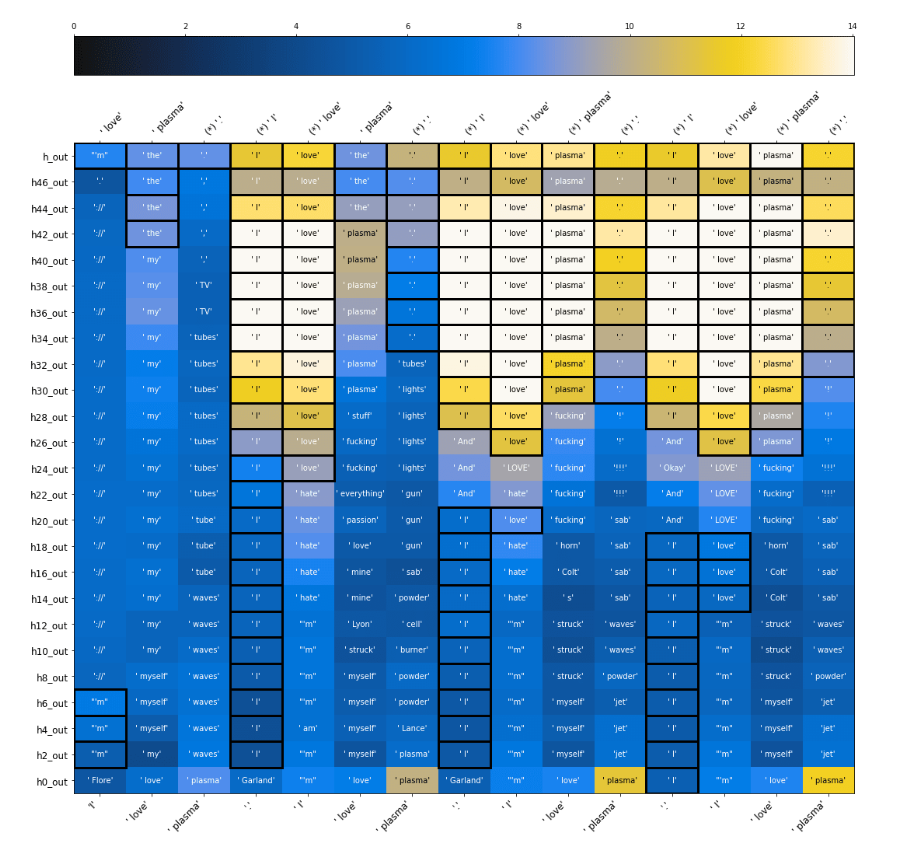

### 2. Rare Token Copying

We have a token that appears very rarely in the training data. Intuitively, one might think: *if this rare token shows up once in the input, the model should keep it “alive” so it can predict it again later*. This would be especially useful in specialized or technical texts.

However, as shown in the visualization below, that's not what happens.

Yes, the model **does** end up predicting the word "plasma" correctly — but it doesn't happen until around **layer 34**. Earlier layers seem to "forget" or scramble the input, and only much later does the model “remember” the token and retrieve it correctly.

This suggests that rare tokens are not simply passed forward as-is; rather, they are **transformed** and then reconstructed from context by later layers.

> 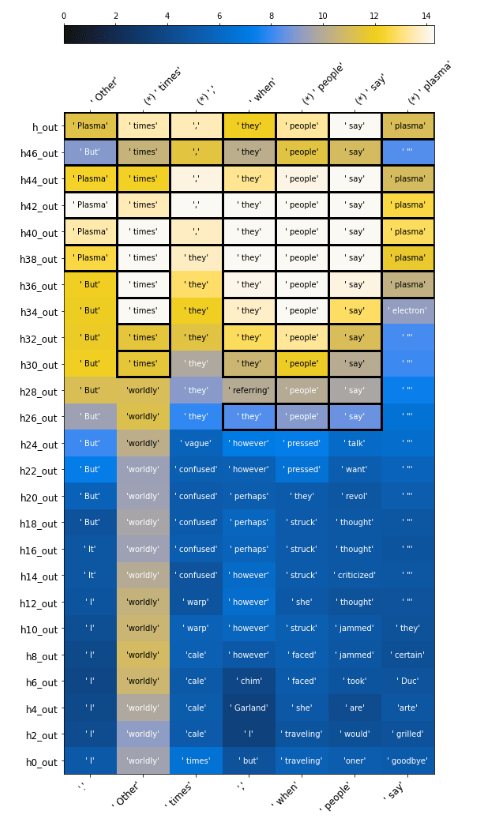